# Value-at-Risk
E.g, 1-day 95% VaR is \$100  </p>
95% percent of the time, we will not lose more than $100 over one day.

In [1]:
import yfinance as yf 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

plt.style.use('bmh')

In [2]:
tickers = ['BA', 'DIS', 'PFE', 'WMT']
num_shares = [100] * len(tickers)
data = yf.download(tickers, period='5y', interval='1d', auto_adjust=True, progress=False)

In [3]:
data.Close

,BA,DIS,PFE,WMT
Date,,,,
2017-02-27,167.788284,105.558479,27.003572,64.824600
2017-02-28,168.536377,105.424400,26.877533,64.092667
2017-03-01,171.977631,106.334152,27.113853,63.658936
2017-03-02,171.117310,105.903214,27.184755,63.939064
2017-03-03,170.359863,106.525673,27.192631,63.279419
...,...,...,...,...
2022-02-17,213.580002,152.949997,48.900002,138.880005
2022-02-18,209.029999,151.360001,48.529999,137.990005
2022-02-22,198.740005,148.089996,47.529999,136.449997


In [4]:
returns = np.log(data.Close / data.Close.shift(1)).dropna()
returns

,BA,DIS,PFE,WMT
Date,,,,
2017-02-28,0.004449,-0.001271,-0.004678,-0.011355
2017-03-01,0.020213,0.008592,0.008754,-0.006790
2017-03-02,-0.005015,-0.004061,0.002612,0.004391
2017-03-03,-0.004436,0.005860,0.000290,-0.010370
2017-03-06,-0.006885,-0.005137,-0.004937,-0.002144
...,...,...,...,...
2022-02-17,-0.024741,-0.021986,-0.015825,0.039284
2022-02-18,-0.021534,-0.010450,-0.007595,-0.006429
2022-02-22,-0.050480,-0.021841,-0.020821,-0.011223


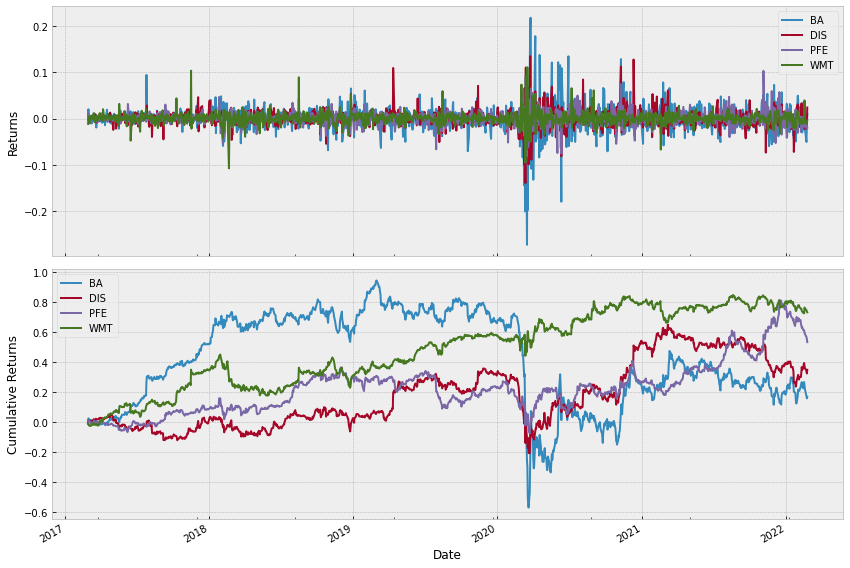

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)

returns.plot(ax=ax[0])
ax[0].set_ylabel('Returns')

returns.cumsum().plot(ax=ax[1])
ax[1].set_ylabel('Cumulative Returns')

plt.tight_layout()
plt.show()

In [6]:
cov_mat = returns.cov()
cov_mat

,BA,DIS,PFE,WMT
BA,0.000898,0.000293,0.000133,0.000078
DIS,0.000293,0.000340,0.000082,0.000065
PFE,0.000133,0.000082,0.000232,0.000067
WMT,0.000078,0.000065,0.000067,0.000188


In [7]:
# Cholesky decomposition
chol_mat = np.linalg.cholesky(cov_mat)
chol_mat

array([[0.02996197, 0.        , 0.        , 0.        ],
       [0.00977911, 0.01563885, 0.        , 0.        ],
       [0.00443177, 0.00249169, 0.01434834, 0.        ],
       [0.00259651, 0.00255294, 0.00344039, 0.01277013]])

In [8]:
T = 1
num_sim = 100_000

rv = np.random.normal(size=(num_sim, len(tickers)))
correlated_rv = np.transpose(np.matmul(chol_mat, np.transpose(rv)))

r = returns.mean(axis=0).values
sigma = returns.std(axis=0).values

In [9]:
S_0 = data.Close.iloc[-1, :].values
P_0 = np.sum(num_shares * S_0)

S_T = S_0 * np.exp((r - 0.5 * (sigma**2))*T + (sigma * np.sqrt(T) * correlated_rv))
P_T = np.sum(num_shares * S_T, axis=1)

P_diff = P_T - P_0
P_diff_sorted = np.sort(P_diff)

In [10]:
percentiles = [0.01, 0.1, 1]
var = np.percentile(P_diff_sorted, percentiles)

In [11]:
for x, y in zip(percentiles, var):
    print(f"1-day VaR with {100-x}% confidence: ${-y:.2f}")

1-day VaR with 99.99% confidence: $79.36
1-day VaR with 99.9% confidence: $64.52
1-day VaR with 99% confidence: $47.81


In [12]:
for x, y in zip(percentiles, var):
    exp_shortfall = P_diff_sorted[P_diff_sorted <= y].mean()
    print(f"{100-x}% Expected Shortfall: ${-exp_shortfall:.2f}")

99.99% Expected Shortfall: $86.96
99.9% Expected Shortfall: $71.67
99% Expected Shortfall: $55.38


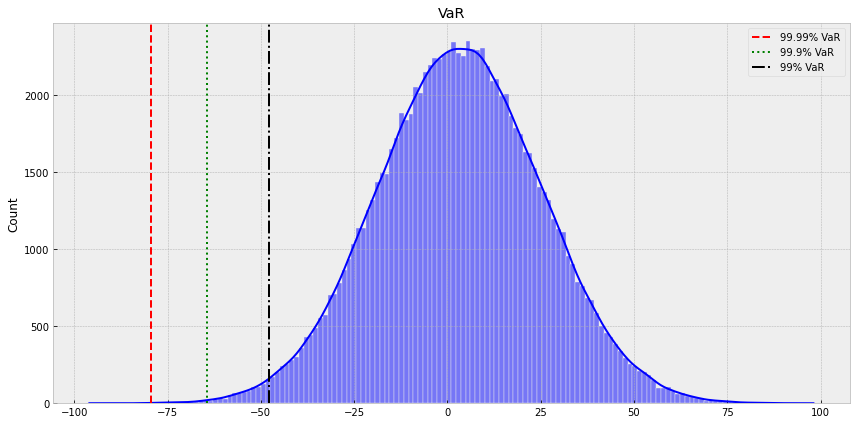

In [13]:
fig, ax = plt.subplots(figsize=(12,6))

sns.histplot(P_diff, ax=ax, kde=True, stat='count')
ax.axvline(var[0], ymin=0, ymax=2500, linestyle='--', label=f'{100-percentiles[0]}% VaR', color='red')
ax.axvline(var[1], ymin=0, ymax=2500, linestyle=':', label=f'{100-percentiles[1]}% VaR', color='green')
ax.axvline(var[2], ymin=0, ymax=2500, linestyle='-.', label=f'{100-percentiles[2]}% VaR', color='black')
ax.set_title('VaR')
ax.legend()

plt.tight_layout()
plt.show()